In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter

In [ ]:
camara_pixel_size = 5 # um
camara_pixels_number = 256
camara_size = camara_pixel_size * camara_pixels_number # um
NA = 1.4 # numerical aperture
MA = 1000 # magnification
physical_pixel_size = camara_pixel_size / MA # um
physical_size = camara_size / MA # um
wavelength = 0.5 # um
diffraction_limit = 0.61 * 0.5 / NA # um

In [ ]:
line_pairs_spacing = [0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24] # um
line_pairs_spacing = np.array(line_pairs_spacing)
line_pairs_spacing = line_pairs_spacing*1000/camara_pixel_size /  # in pixel size

In [13]:
def generate_line_pairs(camara_pixels_number, line_spacing = 20, line_width = 5, line_length = 100):
    
    # 创建一个256x256的黑色图像
    image_array = np.zeros((camara_pixels_number, camara_pixels_number), dtype=np.uint32)

    # 计算线的位置
    center_x = image_array.shape[1] // 2
    center_y = image_array.shape[0] // 2

    # 第一条线的起始和结束位置
    line1_start_x = center_x - line_spacing // 2 - line_width
    line1_end_x = line1_start_x + line_width
    line1_start_y = center_y - line_length // 2
    line1_end_y = line1_start_y + line_length

    # 第二条线的起始和结束位置
    line2_start_x = center_x + line_spacing // 2
    line2_end_x = line2_start_x + line_width
    line2_start_y = center_y - line_length // 2
    line2_end_y = line2_start_y + line_length

    # 绘制第一条线
    image_array[line1_start_y:line1_end_y, line1_start_x:line1_end_x] = 2**32 - 1

    # 绘制第二条线
    image_array[line2_start_y:line2_end_y, line2_start_x:line2_end_x] = 2**32 - 1
    
    return image_array

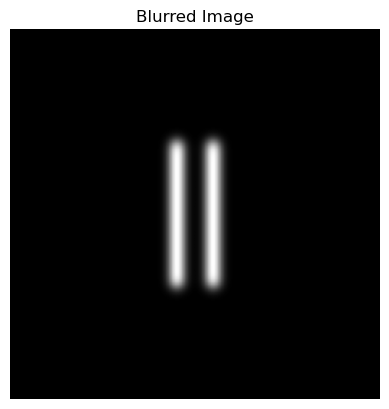

In [16]:
image = generate_line_pairs(camara_pixels_number)

# 对图像应用高斯模糊
blurred_image = gaussian_filter(image, sigma=4)

# 显示模糊后的图像
plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred Image")
plt.axis('off')
plt.show()